Sandra Neubert

Get particle tracking information for the Agulhas Current

### 1. Load Packages

In [1]:
import os
import numpy as np
import xarray as xr
import geopandas as gp
import pandas as pd

import cmocean

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
cartopy.config['data_dir'] = os.getenv('CARTOPY_DIR', cartopy.config.get('data_dir'))

from parcels import FieldSet, Field, ParticleSet, Variable, JITParticle
from parcels import AdvectionRK4, plotTrajectoriesFile, ErrorCode

import math
from datetime import timedelta as delta
from operator import attrgetter

from matplotlib import pyplot as plt
#%config InlineBackend.figure_format = 'retina'
plt.ion()  # To trigger the interactive inline mode

OFES data was in cm/s NOT in m/s!!!!

In [2]:
df = pd.read_csv('C:\\Users\\sandr\\Documents\\Github\\ThesisSandra\\Analysis\\Movement\\Data\\dfOFESStartLocationsGlobal2.csv')
df = df[['lon','lat']]
df

,lon,lat
0,163.65,-74.95
1,163.75,-74.95
2,163.85,-74.95
3,163.95,-74.95
4,164.05,-74.95
...,...,...
3737114,359.50,74.85
3737115,359.60,74.85
3737116,359.70,74.85
3737117,359.80,74.85


In [3]:
df2 = df[df.lat < (-31)] #-32
df3 = df2[df2.lat >(-40)] #-38
df4 = df3[df3.lon >21]
StartLoc = df4[df4.lon <29] #27

In [4]:
#df5

In [5]:
#  StartLocations = df5.reset_index(drop=True)       
# for i in np.arange(0, len(StartLocations)):
#     lonVals = np.linspace(StartLocations.lon[i]-0.05, StartLocations.lon[i]+0.05, 1) #to get even steps between released particles within and between cells (released every 0.1°)
#     latVals = np.linspace(StartLocations.lat[i]-0.05, StartLocations.lat[i]+0.05, 1)
#     #print(i)
    
#     for j in np.arange(0, len(lonVals)):
#         lonRep = np.repeat(lonVals[j], 1)
#         partRelease = pd.concat([pd.DataFrame({"lon": lonRep}), pd.DataFrame({"lat":latVals})], axis=1)
#         if i == 0 and j == 0:
#             StartLoc = partRelease
#         else:
#             StartLoc = pd.concat([StartLoc, partRelease])
# StartLoc

In [6]:
#StartLoc[4713:4773]

### 2. Specify Data Location and Filenames

In [7]:
dataPath = "C:\\Users\\sandr\\Documents\\Github\ThesisSandra\\Analysis\\Movement\\TracerDataAndOutput\\OFES\\"
ufiles = dataPath + "OfESncep01globalmmeanuMS.nc"
vfiles = dataPath + "OfESncep01globalmmeanvMS.nc"

filenames = {'U': ufiles,
             'V': vfiles}

variables = {'U': 'uvel',
             'V': 'vvel'}
dimensions = {'lat': 'latitude',
              'lon': 'longitude',
              'time': 'time'}

### 3. Define Fieldset

In [8]:
fieldset = FieldSet.from_netcdf(filenames, variables, dimensions)
fieldset.add_constant('maxage', 1.*86400) #get rid of particles after 4 days

### 4. Define Simulation Conditions

In [9]:
npartNumber = len(StartLoc) #release Locations

lon_array = StartLoc.lon
lat_array = StartLoc.lat

#lon_array = np.linspace(140, 141, num=npartNumber)
#lat_array = np.linspace(5, 6, num=npartNumber)
# time = np.arange(0, npart) * delta(hours=2).total_seconds()  # release every particle two hours later

In [10]:
npart = 1 #how many particles are released at each location (every time)
lon = np.repeat(lon_array, npart)
lat = np.repeat(lat_array, npart)

# How often to release the particles
repeatdt = None #delta(days = 1) # release from the same set of locations every X day

#runtime = end_time-start_time + delta(days=1) #for later
runtime = delta(days=1) #how long is total runtime (how long each individual tracer is tracked i defined by maxage)

# Define when you want tracking to start (i.e. start of the spawning season)
#pset_start = (start_time-datetime.strptime(str(fieldset.time_origin)[0:10], "%Y-%m-%d")).total_seconds()
# Create an array of release times 
#release_times = pset_start + (np.arange(0, runtime.days) * repeatdt.total_seconds())  
# Multiply the release times by the number of particles
#time = np.repeat(release_times, npart)

time = 0 #np.arange(0, npart) * delta(days = 1).total_seconds() #Here: to only release at beginning of data: = 0
time

0

In [11]:
len(lon_array)

4850

### 5. Define Particle Properties

In [12]:
class SampleParticle(JITParticle):         # Define a new particle class
        sampled = Variable('sampled', dtype = np.float32, initial = 0, to_write=False)
        age = Variable('age', dtype=np.float32, initial=0.) # initialise age
        distance = Variable('distance', initial=0., dtype=np.float32)  # the distance travelled
        prev_lon = Variable('prev_lon', dtype=np.float32, to_write=False,
                            initial=0)  # the previous longitude
        prev_lat = Variable('prev_lat', dtype=np.float32, to_write=False,
                            initial=0)  # the previous latitude
        #u_vel = Variable('u_vel', dtype = np.float32, initial = 0)
        #v_vel = Variable('v_vel', dtype = np.float32, initial = 0)
        #beached = Variable('beached', dtype = np.float32, initial = 0)
    
def DeleteParticle(particle, fieldset, time): #needed to avoid error mesasage of Particle out of bounds
    particle.delete()
    
# Define all the sampling kernels
def SampleDistance(particle, fieldset, time):
    # Calculate the distance in latitudinal direction (using 1.11e2 kilometer per degree latitude)
    lat_dist = (particle.lat - particle.prev_lat) * 1.11e2
    # Calculate the distance in longitudinal direction, using cosine(latitude) - spherical earth
    lon_dist = (particle.lon - particle.prev_lon) * 1.11e2 * math.cos(particle.lat * math.pi / 180)
    # Calculate the total Euclidean distance travelled by the particle
    particle.distance += math.sqrt(math.pow(lon_dist, 2) + math.pow(lat_dist, 2))
    particle.prev_lon = particle.lon  # Set the stored values for next iteration.
    particle.prev_lat = particle.lat

def SampleAge(particle, fieldset, time):
    particle.age = particle.age + math.fabs(particle.dt)
    if particle.age > fieldset.maxage:
           particle.delete()
    
def SampleInitial(particle, fieldset, time): # do we have to add particle.age and particle.ageRise
        if particle.sampled == 0:
            particle.distance = particle.distance
            particle.prev_lon = particle.lon
            particle.prev_lat = particle.lat
            #particle.u_vel = fieldset.U[time, particle.depth, particle.lat, particle.lon]
            #particle.v_vel = fieldset.V[time, particle.depth, particle.lat, particle.lon]
            #particle.beached = particle.beached
            particle.sampled = 1
               
pset = ParticleSet.from_list(fieldset, 
                             pclass=SampleParticle, 
                             time=time, 
                             lon=lon, 
                             lat=lat,
                             repeatdt=repeatdt)


In [13]:
kernels = SampleInitial + pset.Kernel(AdvectionRK4) + SampleAge + SampleDistance 

In [14]:
# pset = ParticleSet.from_list(fieldset, 
#                              pclass=DistParticle, 
#                              time=time, 
#                              lon=lon, 
#                              lat=lat,
#                              repeatdt=repeatdt)

In [15]:
output_nc_dist = 'ParcelsOutput\\HighCurrentAghulas.zarr'
try:
    os.remove(output_nc_dist)
except OSError:
    pass

file_dist = pset.ParticleFile(name=output_nc_dist, 
                                outputdt=delta(hours=1))

pset.execute(kernels,  # Add kernels using the + operator.
             runtime=runtime,
             dt=delta(minutes=5),
             output_file=file_dist,
             recovery={ErrorCode.ErrorOutOfBounds: DeleteParticle})


INFO: Compiled ArraySampleParticleSampleInitialAdvectionRK4SampleAgeSampleDistance ==> C:\Users\sandr\AppData\Local\Temp\parcels-tmp\libc6c56263ad15a3ef4b5397c3a4b19ccf_0.dll


In [16]:
parcels_dist = xr.open_dataset(output_nc_dist)
parcels_dist

C:\Users\sandr\.conda\envs\py3_parcels3\lib\site-packages\xarray\backends\plugins.py:139: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
C:\Users\sandr\.conda\envs\py3_parcels3\lib\site-packages\xarray\backends\plugins.py:139: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


<xarray.Dataset>
Dimensions:     (trajectory: 4850, obs: 25)
Coordinates:
  * obs         (obs) int32 0 1 2 3 4 5 6 7 8 9 ... 16 17 18 19 20 21 22 23 24
  * trajectory  (trajectory) int64 0 1 2 3 4 5 ... 4844 4845 4846 4847 4848 4849
Data variables:
    age         (trajectory, obs) float32 ...
    distance    (trajectory, obs) float32 ...
    lat         (trajectory, obs) float32 ...
    lon         (trajectory, obs) float32 ...
    time        (trajectory, obs) datetime64[ns] ...
    z           (trajectory, obs) float32 ...
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_mesh:           spherical
    parcels_version:        2.4.0

In [17]:
TracerNumber = parcels_dist.distance.values.shape[0]
TotalDistance = []
for i in range(0, TracerNumber):
        distance = parcels_dist.distance.values
        maxDist = max(distance[i,])
        TotalDistance.append(maxDist)
        #print(i)
TotalDistance

[54.39916,
 54.29986,
 52.96472,
 51.99257,
 51.943707,
 52.09773,
 51.909744,
 51.42855,
 50.77478,
 49.598225,
 47.611443,
 44.871296,
 41.870163,
 39.112476,
 36.746883,
 34.868595,
 33.48216,
 32.50816,
 31.814663,
 31.280329,
 30.867146,
 30.49493,
 30.09077,
 29.470936,
 28.230448,
 26.404436,
 24.466356,
 23.234133,
 22.922144,
 23.373238,
 24.146893,
 24.605028,
 25.201977,
 27.536657,
 33.003414,
 40.809376,
 48.75648,
 55.02886,
 59.084927,
 60.223656,
 58.66443,
 56.39282,
 52.79967,
 46.86478,
 39.265602,
 31.652601,
 25.311419,
 20.753208,
 18.341228,
 18.50372,
 21.147991,
 23.996695,
 26.16905,
 28.639513,
 31.307787,
 33.182266,
 33.31774,
 31.663864,
 29.476652,
 27.751854,
 27.042398,
 26.723555,
 24.118736,
 17.90903,
 9.861256,
 4.648947,
 4.54316,
 7.286892,
 9.209609,
 8.617724,
 7.3045197,
 7.878116,
 10.003843,
 12.810864,
 15.777955,
 18.228943,
 19.885368,
 20.72033,
 20.597387,
 19.490545,
 56.649456,
 56.193165,
 54.3778,
 53.05116,
 52.393696,
 51.68859,
 5

In [18]:
TotalDistance25 = np.repeat(TotalDistance, 25).reshape(parcels_dist.distance.values.shape[0], 25)
parcels_dist['TotalDistance'] = (['trajectory', 'obs'],TotalDistance25)
parcels_dist

<xarray.Dataset>
Dimensions:        (trajectory: 4850, obs: 25)
Coordinates:
  * obs            (obs) int32 0 1 2 3 4 5 6 7 8 ... 16 17 18 19 20 21 22 23 24
  * trajectory     (trajectory) int64 0 1 2 3 4 5 ... 4845 4846 4847 4848 4849
Data variables:
    age            (trajectory, obs) float32 ...
    distance       (trajectory, obs) float32 0.0 2.515 5.003 ... 36.19 37.46
    lat            (trajectory, obs) float32 ...
    lon            (trajectory, obs) float32 ...
    time           (trajectory, obs) datetime64[ns] ...
    z              (trajectory, obs) float32 ...
    TotalDistance  (trajectory, obs) float32 54.4 54.4 54.4 ... 37.46 37.46
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_mesh:           spherical
    parcels_version:        2.4.0

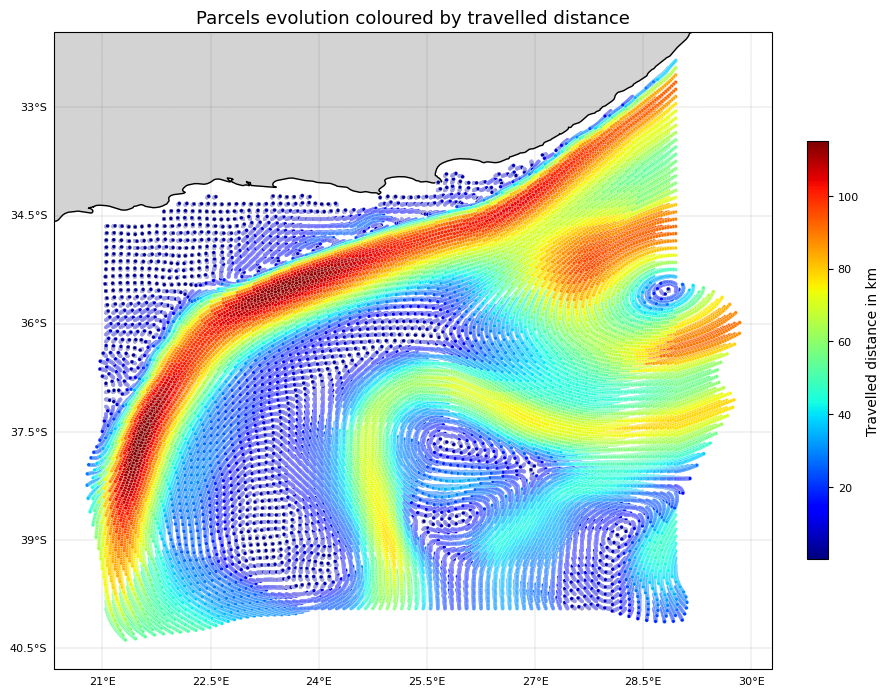

<Figure size 640x480 with 0 Axes>

In [19]:
# Figure size
size = (9, 10)

# Color from cmocean
color = cmocean.cm.speed

# Defining the figure
fig = plt.figure(figsize=size, facecolor='w', edgecolor='k')

# Axes with Cartopy projection
ax = plt.axes(projection=ccrs.PlateCarree())


# Title
plt.title('Parcels evolution coloured by travelled distance',
          fontsize=13
         )

# Plot lat/lon grid 
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.1, color='k', alpha=1, 
                  linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 8}
gl.ylabel_style = {'size': 8} 

# Add map features with Cartopy 
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', 
                                            edgecolor='face', 
                                            facecolor='lightgray'))
ax.coastlines(linewidth=1)

distmin = min(TotalDistance)#parcels_dist.distance.min().item()
distmax = max(TotalDistance)#parcels_dist.distance.max().item()

for k in range(parcels_dist.lon.shape[0]):
    sc = plt.scatter(parcels_dist.lon.isel(trajectory=k), parcels_dist.lat.isel(trajectory=k), s=7, 
               c=parcels_dist.TotalDistance.isel(trajectory=k), edgecolors='w', 
               cmap='jet', vmin=distmin, vmax=distmax, 
               linewidth=0.2, transform=ccrs.PlateCarree()).set_zorder(11) 

# Color bar
cbar2 = plt.colorbar(sc, ax=ax, fraction=0.027, pad=0.045)
cbar2.set_label('Travelled distance in km', rotation=90, 
               labelpad=5, fontsize=10)
cbar2.ax.tick_params(labelsize=8)

plt.tight_layout()
plt.show()
fig.savefig('C:\\Users\\sandr\\Documents\\Github\\ThesisSandra\\Analysis\\Movement\\Figures\\ParticleTracking\\HighCurrentArea1Aghulas.png')
fig.clear()
plt.close(fig)
plt.clf()

Make plot (histogram), that shows how many particles move further than one grid cell (one further, two further, etc.)
For this: 
- assign indices to the centroids
- find the nearest neighbour centroid of BOATS for the time = 0 and assign them one of the centroid indices if they have the same starting centroid (i.e. started in same grid cell)
- find the nearest neighbour centroid at time = 24 (25?) and assign a centroid index
- loop through all the centroid indices and find out where the particles move to and count: how many stayed, how many moved to the 8 adjacent cells, how many to 16 adjacent cells (further than 8) etc and make histogram
- for those further than 8 adjacent cells (if not too many): how far did they go?



In [20]:
# BOATSCentr = StartLocations 
# BOATSCentr

In [21]:
# StartLoc

In [22]:
# boatsIndex = BOATSCentr.loc[BOATSCentr.index.repeat(100)]
# boatsIndex = boatsIndex.index
# boatsIndex

In [23]:
# StartLoc["IndexBoats"] = boatsIndex
# StartLoc

In [24]:
dfParcels = parcels_dist.to_dataframe()
dfParcels.to_csv('C:\\Users\\sandr\\Documents\\Github\\ThesisSandra\\Analysis\\Movement\\Data\\dfParcelsAghulasNew.csv')


Other areas to run:
69.66° N, 3.18° E (0.3 m/s); 75.37° N, 14.20° E (0.3 m/s); 70.06° N, 12.49° E --> so 69.5°N - 74.5°N; 2.5°E -12.5°E